In [1]:
# test mnist gan for downsampled climate model output

In [2]:
# important things

# the input is currently reduced to 24x32 (from actual 24x36) because like this no major interference with the 
    # architecture was needed -> ways out: try to make 1 larger layer & cut again -> additional conv? (maybe better in
    # another script ^^)
    # + also:  try to get more realistic fields by less strong downsampling (factor 2 instead of 4) -> would
    # probably also require an additional layer in both generator & discriminator


# to do: 
    # let run for longer (10'000 iterations to start with?)
    # do for precip (ATTENTION: clim has hardcoded that use T fields -> maybe copy fct again + do for precip
        # or introduce additional argument specifying if precip or tas wanted)

# would be nice to do:
    # change architecture to make 36x24 possible (or even larger ones)
    # add second input & output channel (ie do T & precip)
    # make the GAN conditional on land/sea + could also do on month (man, that'd be really cool... & probably 
        # also really impossible for me :'( at least with the amount of time & knowledge available')
    # try on ETH gpu

In [1]:
import imp



In [2]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')

%matplotlib inline

import os, sys
sys.path.append(os.getcwd())

import time
import pickle


import numpy as np
import sklearn.datasets
import tensorflow as tf

import tflib as lib
import tflib.ops.linear
import tflib.ops.conv2d
import tflib.ops.batchnorm
import tflib.ops.deconv2d
import tflib.save_images
import tflib.mnist
import tflib.clim
import tflib.plot



/home/beusch/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/beusch/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/beusch/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/beusch/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/beusch/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/beusch/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line

In [3]:
from sklearn.externals import joblib # same purpose as pickle but more efficient with big data / can only pickle to disk
#from sklearn import preprocessing

In [4]:
# load in the climate data


import netCDF4 as nc

import matplotlib.pyplot as plt

import numpy as np

from skimage.measure import block_reduce


import cartopy
import cartopy.crs as ccrs

# from xarray
def _infer_interval_breaks(coord, axis=0):
    """
    >>> _infer_interval_breaks(np.arange(5))
    array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])
    >>> _infer_interval_breaks([[0, 1], [3, 4]], axis=1)
    array([[-0.5,  0.5,  1.5],
           [ 2.5,  3.5,  4.5]])
    """


    coord = np.asarray(coord)
    deltas = 0.5 * np.diff(coord, axis=axis)
    if deltas.size == 0:
        deltas = np.array(0.0)
    first = np.take(coord, [0], axis=axis) - np.take(deltas, [0], axis=axis)
    last = np.take(coord, [-1], axis=axis) + np.take(deltas, [-1], axis=axis)
    trim_last = tuple(slice(None, -1) if n == axis else slice(None)
                      for n in range(coord.ndim))
    return np.concatenate([first, coord[trim_last] + deltas, last], axis=axis)


# from xarray
def _is_monotonic(coord, axis=0):
    """
    >>> _is_monotonic(np.array([0, 1, 2]))
    True
    >>> _is_monotonic(np.array([2, 1, 0]))
    True
    >>> _is_monotonic(np.array([0, 2, 1]))
    False
    """
    coord = np.asarray(coord)

    if coord.shape[axis] < 3:
        return True
    else:
        n = coord.shape[axis]
        delta_pos = (coord.take(np.arange(1, n), axis=axis) >=
                     coord.take(np.arange(0, n - 1), axis=axis))
        delta_neg = (coord.take(np.arange(1, n), axis=axis) <=
                     coord.take(np.arange(0, n - 1), axis=axis))
    
    return np.all(delta_pos) or np.all(delta_neg)

# from xarray
def infer_interval_breaks(x, y, clip=False):
    """"
    find edges of gridcells, given their centers
    """
    
    if len(x.shape) == 1:
        x = _infer_interval_breaks(x)
        y = _infer_interval_breaks(y)
    else:
        # we have to infer the intervals on both axes
        x = _infer_interval_breaks(x, axis=1)
        x = _infer_interval_breaks(x, axis=0)
        y = _infer_interval_breaks(y, axis=1)
        y = _infer_interval_breaks(y, axis=0)

    if clip:
        y = np.clip(y, -90, 90)
        
    return x, y


In [5]:
dir_pictl= '/home/beusch/Lea/phd/data/picontrol_CESM/tas/'
tas_pictl= 'tas_CESM12-LE_pictl_0500-5282_yearmean_shiftgrid.nc'

In [6]:
# open the netcdf file in reading mode
ncobj = nc.Dataset(dir_pictl+tas_pictl, mode='r')
 
# Read in what you need (you can also index it like a numpy array if you need just a part of it)
tas = ncobj['TREFHT'][:].data
lon = ncobj['lon'][:].data
lat = ncobj['lat'][:].data
# Close the netcdf file object
ncobj.close()

In [7]:
# the lon / lat grid
lons, lats = np.meshgrid(lon,lat)

# the lon / lat for the plotting with pcolormesh
lon_pc, lat_pc = infer_interval_breaks(lon, lat)

In [8]:
tas_avg= np.average(tas[:100],axis=0)

tas_an = tas-tas_avg

In [9]:
tas_an.max(),tas_an.min()

(10.469452, -10.259338)

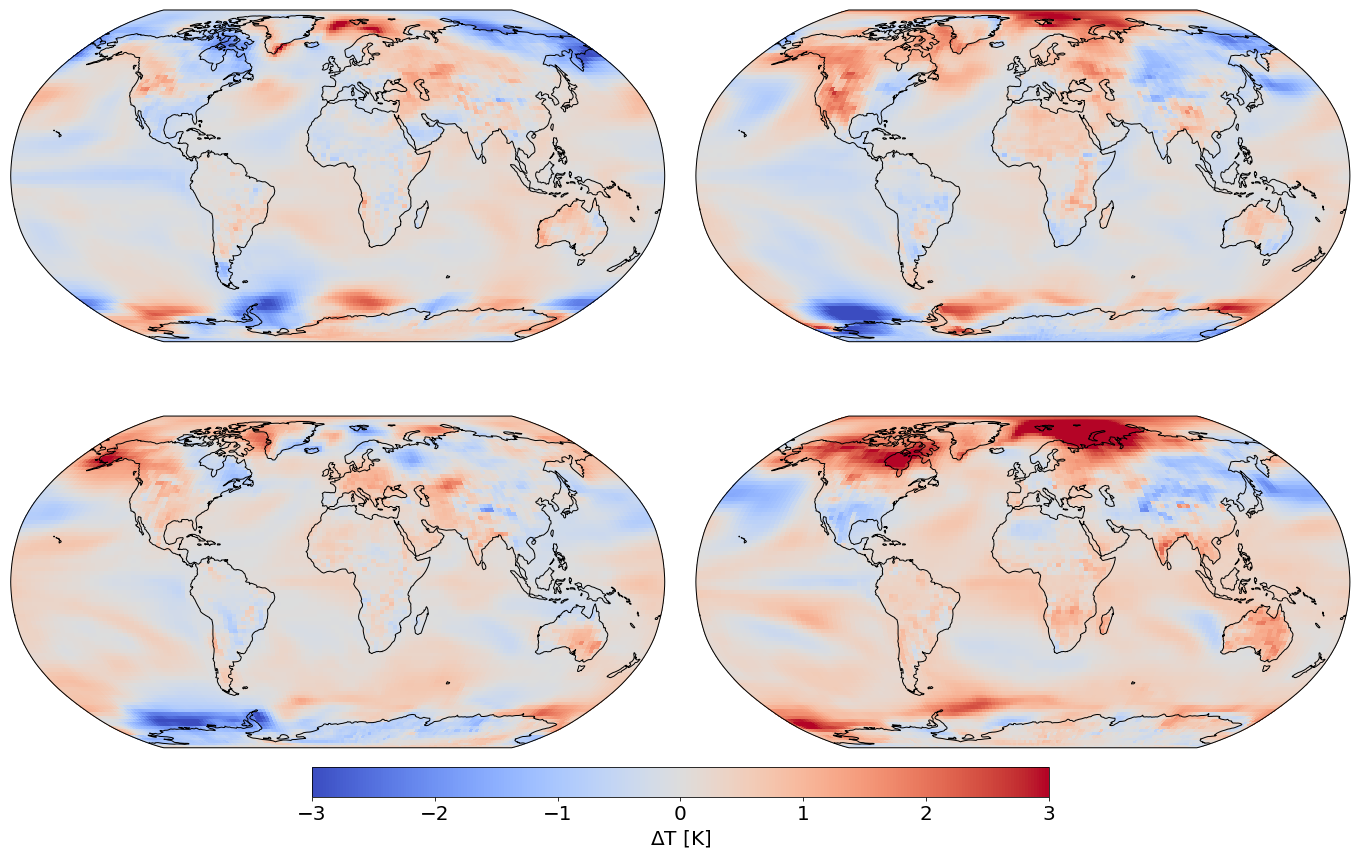

In [10]:
### create the plot
plt.figure(figsize=(24, 18))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.default':'regular'}) 
grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0) # create a grid for the subplots


ax1 = plt.subplot(grid[0,:2], projection=ccrs.Robinson(central_longitude=0))
ax1.coastlines()
mesh1 = ax1.pcolormesh(lon_pc, lat_pc, tas_an[50], cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())

ax2 = plt.subplot(grid[0,2:], projection=ccrs.Robinson(central_longitude=0))
ax2.coastlines()
mesh = ax2.pcolormesh(lon_pc, lat_pc, tas_an[2500],cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())

ax3 = plt.subplot(grid[1,:2], projection=ccrs.Robinson(central_longitude=0))
ax3.coastlines()
mesh3 = ax3.pcolormesh(lon_pc, lat_pc, tas_an[3500], cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())

ax4 = plt.subplot(grid[1,2:], projection=ccrs.Robinson(central_longitude=0))
ax4.coastlines()
mesh = ax4.pcolormesh(lon_pc, lat_pc, tas_an[4500],cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())

cbar=plt.colorbar(mesh,ax=[ax1,ax2,ax3,ax4],orientation='horizontal',shrink=0.55,pad=0.02,aspect=25)
cbar.set_label('$\Delta T$ [K]')  

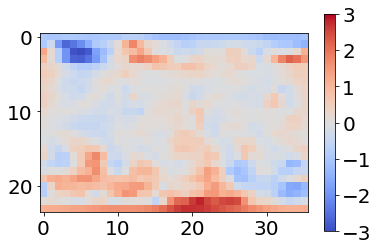

In [11]:
plt.imshow(block_reduce(tas_an[2500],(4,4), func=np.mean),cmap='coolwarm',vmin=-3,vmax=3)
plt.colorbar()

In [12]:
block_reduce(tas_an[50],(4,4),func=np.mean).shape

(24, 36)

In [13]:
lon_pc_red4=block_reduce(lon_pc.reshape(1,len(lon_pc)),(1,4),func=np.mean,cval=183.2).flatten()

lat_pc_red4=block_reduce(lat_pc.reshape(1,len(lat_pc)),(1,4),func=np.mean,cval=93.78).flatten()

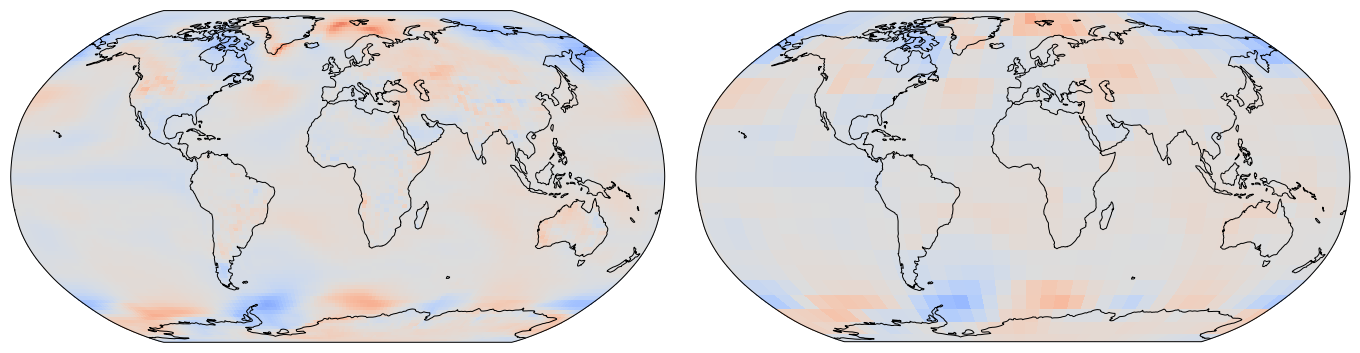

In [15]:
### create the plot
plt.figure(figsize=(24, 18))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.default':'regular'}) 
grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0) # create a grid for the subplots


ax1 = plt.subplot(grid[0,:2], projection=ccrs.Robinson(central_longitude=0))
ax1.coastlines()
mesh1 = ax1.pcolormesh(lon_pc, lat_pc, tas_an[50], cmap='coolwarm',vmin=-6,vmax=6,transform=ccrs.PlateCarree())

ax2 = plt.subplot(grid[0,2:], projection=ccrs.Robinson(central_longitude=0))
ax2.coastlines()
test = block_reduce(tas_an[50],(4,4),func=np.mean)

mesh = ax2.pcolormesh(lon_pc_red4, lat_pc_red4, test,cmap='coolwarm',vmin=-6,vmax=6,transform=ccrs.PlateCarree())

In [16]:
tas_an_red4 = block_reduce(tas_an,(1,4,4),func=np.mean,cval=0)

tas_an_red4.shape, 24*32,tas_an.shape

((4783, 24, 36), 768, (4783, 96, 144))

In [17]:
# do a linear transformation of the data before to be between 0.2 & 0.8 -> network output now between 0 & 1 possible
    # hence should learn to ouput between 0.2 & 0.8 again -> I can reaply the linear transformation at the end

max_tas=tas_an_red4.max()
min_tas=tas_an_red4.min()

# y = a+b*x

b= (0.9-0.1)/(max_tas-min_tas)
a = 0.9-b*max_tas

a,b, max_tas,min_tas

(0.48260456453658, 0.04561865352283389, 9.149666, -8.387021)

In [18]:
def lin_trans(x):
    y=a+b*x
    
    return y


def inv_lin_trans(y):
    x= (y-a)/b
    
    return x

(array([749., 132.]), array([0.7 , 0.75, 0.8 ]), <a list of 2 Patch objects>)

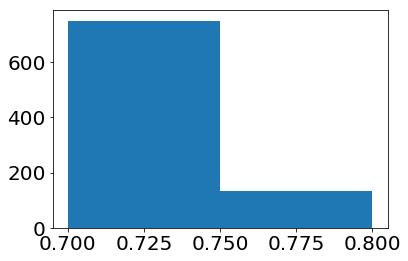

In [19]:
# here I transform the data to a 0.1-0.9 scale to make them compatible with the input of my GAN

tas_an_red4_lintrans=lin_trans(tas_an_red4)
plt.hist(tas_an_red4_lintrans.flatten(),bins=np.arange(0.7,0.82,0.05))

In [21]:
# Here I save the data in the same format as the handwritten digits of my GAN were saved in
train=(tas_an_red4_lintrans[:,:,2:-2].reshape(4783,24*32)[:4000],) # to save data in same way as the digits are saved in
test=(tas_an_red4_lintrans[:,:,2:-2].reshape(4783,24*32)[4000:4400],)
dev=tas_an_red4_lintrans[:,:,2:-2].reshape(4783,24*32)[4400:]
dev = (dev[:(dev.shape[0]//50)*50],)
with open(os.path.join(dir_pictl, 'train_tas.pkl'), 'wb') as f:
    pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(dir_pictl, 'test_tas.pkl'), 'wb') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(dir_pictl, 'dev_tas.pkl'), 'wb') as f:
    pickle.dump(dev, f, protocol=pickle.HIGHEST_PROTOCOL)




train[0].shape,test[0].shape,dev[0].shape

((4000, 768), (400, 768), (350, 768))

In [ ]:
# Here the GAN starts

In [23]:
height=24
width=32

In [24]:
MODE = 'wgan-gp' # dcgan, wgan, or wgan-gp
DIM = 64 # Model dimensionality
BATCH_SIZE = 50 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
ITERS = 10001#200000 # How many generator iterations to train for 
OUTPUT_DIM = height*width #784 # Number of pixels in MNIST (28*28)

lib.print_model_settings(locals().copy())

Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DIM: 64
	ITERS: 10001
	LAMBDA: 10
	MODE: wgan-gp
	OUTPUT_DIM: 768


In [25]:
def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

In [26]:
def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear', 
        n_in, 
        n_out, 
        inputs,
        initialization='he'
    )
    return tf.nn.relu(output)

In [27]:
def LeakyReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear', 
        n_in, 
        n_out, 
        inputs,
        initialization='he'
    )
    return LeakyReLU(output)

In [28]:
def Generator(n_samples, noise=None):
    if noise is None:
        noise = tf.random_normal([n_samples, 128])
    output = lib.ops.linear.Linear('Generator.Input', 128, 4*4*4*DIM, noise)
    

    output = tf.nn.relu(output)
    output = tf.reshape(output, [-1, 4*DIM, 4, 4])
    output = lib.ops.deconv2d.Deconv2D('Generator.2', 4*DIM, 2*DIM, 5, output)

    output = tf.nn.relu(output)
    
    #output = output[:,:,:7,:7]
    #output = output[:,:,:6,:14] # attempt to get right output amount (not that easy ^^ -> retry with 28 x 28)
    
    
    output = lib.ops.deconv2d.Deconv2D('Generator.3', 2*DIM, DIM, 5, output)

    output = tf.nn.relu(output)
    output = lib.ops.deconv2d.Deconv2D('Generator.5', DIM, 1, 5, output)
    output = output[:,:,:height,:width]
    output = tf.nn.sigmoid(output) 
    


    return tf.reshape(output, [-1, OUTPUT_DIM])


In [29]:
#lib.ops.linear.Linear?

In [30]:
def Discriminator(inputs):
    output = tf.reshape(inputs, [-1, 1, height, width])

    output = lib.ops.conv2d.Conv2D('Discriminator.1', 1, DIM, 5, output,stride=2)
    output = LeakyReLU(output)
    print('1',output)
    output = lib.ops.conv2d.Conv2D('Discriminator.2', DIM, 2*DIM, 5, output, stride=2)
    print(output)

    output = LeakyReLU(output)
    print('2',output)
    output = lib.ops.conv2d.Conv2D('Discriminator.3', 2*DIM, 4*DIM, 5, output, stride=2)
    print(output)

    output = LeakyReLU(output)
    print('3',output)

    w = width // 8
    h = height // 8
    
    output = tf.reshape(output, [-1, w*h * 4*DIM])
    print('4',output.shape)
    output = lib.ops.linear.Linear('Discriminator.Output',  w*h * 4*DIM, 1, output) # test to do sigmoid output

    
    print('5',output)

    return tf.reshape(output, [-1])

In [31]:
real_data = tf.placeholder(tf.float32, shape=[BATCH_SIZE, OUTPUT_DIM])
fake_data = Generator(BATCH_SIZE)

disc_real = Discriminator(real_data)
disc_fake = Discriminator(fake_data)

gen_params = lib.params_with_name('Generator')
disc_params = lib.params_with_name('Discriminator')



if MODE == 'wgan-gp':
    gen_cost = -tf.reduce_mean(disc_fake)
    disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

    alpha = tf.random_uniform(
        shape=[BATCH_SIZE,1], 
        minval=0.,
        maxval=1.
    )
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    gradients = tf.gradients(Discriminator(interpolates), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    disc_cost += LAMBDA*gradient_penalty

    gen_train_op = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5,
        beta2=0.9
    ).minimize(gen_cost, var_list=gen_params)
    disc_train_op = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5, 
        beta2=0.9
    ).minimize(disc_cost, var_list=disc_params)

    clip_disc_weights = None



('1', <tf.Tensor 'Maximum:0' shape=(50, 64, 12, 16) dtype=float32>)
Tensor("Discriminator.2/BiasAdd:0", shape=(50, 128, 6, 8), dtype=float32)
('2', <tf.Tensor 'Maximum_1:0' shape=(50, 128, 6, 8) dtype=float32>)
Tensor("Discriminator.3/BiasAdd:0", shape=(50, 256, 3, 4), dtype=float32)
('3', <tf.Tensor 'Maximum_2:0' shape=(50, 256, 3, 4) dtype=float32>)
('4', TensorShape([Dimension(50), Dimension(3072)]))
('5', <tf.Tensor 'Discriminator.Output/BiasAdd:0' shape=(50, 1) dtype=float32>)
('1', <tf.Tensor 'Maximum_3:0' shape=(50, 64, 12, 16) dtype=float32>)
Tensor("Discriminator.2_1/BiasAdd:0", shape=(50, 128, 6, 8), dtype=float32)
('2', <tf.Tensor 'Maximum_4:0' shape=(50, 128, 6, 8) dtype=float32>)
Tensor("Discriminator.3_1/BiasAdd:0", shape=(50, 256, 3, 4), dtype=float32)
('3', <tf.Tensor 'Maximum_5:0' shape=(50, 256, 3, 4) dtype=float32>)
('4', TensorShape([Dimension(50), Dimension(3072)]))
('5', <tf.Tensor 'Discriminator.Output_1/BiasAdd:0' shape=(50, 1) dtype=float32>)
('1', <tf.Tensor '

In [32]:
#imp.reload(tflib.save_images)

In [33]:
# new test version
# For saving samples

def generate_image(frame, true_dist, nr_samples):
    fixed_noise = tf.constant(np.random.normal(size=(nr_samples, 128)).astype('float32'))

    fixed_noise_samples = Generator(nr_samples, noise=fixed_noise)

    
    samples = session.run(fixed_noise_samples)
    lib.save_images.save_images(
        samples.reshape((nr_samples, height, width)), 
        'samples_{}.png'.format(frame)
    )
    # maybe try to save samples here?
    samples_to_save=samples.reshape((nr_samples, height, width))
    save_file_name = os.path.join(dir_pictl, 'samples_{}.pkl'.format(frame))
    with open(save_file_name, 'wb') as f:
        pickle.dump(samples_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
# Dataset iterator
train_gen, dev_gen, test_gen = lib.clim.load(BATCH_SIZE, BATCH_SIZE)
def inf_train_gen():
    while True:
        for images in train_gen():
            yield images

Instructions for updating:
Use `tf.global_variables_initializer` instead.
2000
iter 0	train disc cost	0.130324497819	dev disc cost	-0.0546124242246	time	3.9234161377
iter 1	train disc cost	-0.226779714227	time	4.09844207764
iter 2	train disc cost	-0.371451109648	time	3.80679392815
iter 3	train disc cost	-0.437050521374	time	3.83899903297
iter 4	train disc cost	-0.439151465893	time	4.80846905708
iter 99	train disc cost	-0.335024029016	time	5.15824193202
128
iter 199	train disc cost	-0.371708631516	dev disc cost	-0.415835559368	time	5.17307921171
128
iter 299	train disc cost	-0.261591225863	dev disc cost	-0.304191380739	time	5.16117518902
128
iter 399	train disc cost	-0.18469107151	dev disc cost	-0.20568986237	time	5.67116279602
128
iter 499	train disc cost	-0.143360003829	dev disc cost	-0.140903457999	time	5.28132898808
128
iter 599	train disc cost	-0.11883007735	dev disc cost	-0.125772029161	time	5.42185559034
128
iter 699	train disc cost	-0.104695990682	dev disc cost	-0.105175495148	t

128
iter 7999	train disc cost	-0.021684486419	dev disc cost	-0.0281926412135	time	5.48125151873
2000
iter 8099	train disc cost	-0.0194663666189	dev disc cost	0.000123111269204	time	5.47897706985
128
iter 8199	train disc cost	-0.0223595239222	dev disc cost	-0.0321361832321	time	5.44482726336
128
iter 8299	train disc cost	-0.0204004924744	dev disc cost	-0.0680764764547	time	5.52694250345
128
iter 8399	train disc cost	-0.0249504167587	dev disc cost	-0.021688265726	time	5.51271980047
128
iter 8499	train disc cost	-0.0240627527237	dev disc cost	0.0258013177663	time	5.46651311398
128
iter 8599	train disc cost	-0.0177704431117	dev disc cost	-0.0138648999855	time	5.57958821297
128
iter 8699	train disc cost	-0.0237930584699	dev disc cost	-0.0074500804767	time	5.57515360594
128
iter 8799	train disc cost	-0.0239866822958	dev disc cost	-0.0451564975083	time	5.54170088053
128
iter 8899	train disc cost	-0.0295543614775	dev disc cost	0.00497685046867	time	5.4974554944
128
iter 8999	train disc cost	-0

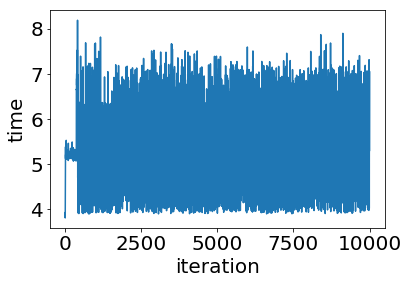

In [37]:
# Train loop
with tf.Session() as session:

    
    session.run(tf.initialize_all_variables())

    
    
    gen = inf_train_gen()

    for iteration in xrange(ITERS):
        start_time = time.time()


        
        if iteration > 0:
            _ = session.run(gen_train_op)
            


        if MODE == 'dcgan':
            disc_iters = 1
        else:
            disc_iters = CRITIC_ITERS
        for i in xrange(disc_iters):
            _data = gen.next()
            _disc_cost, _ = session.run(
                [disc_cost, disc_train_op],
                feed_dict={real_data: _data}
            )
            if clip_disc_weights is not None:
                _ = session.run(clip_disc_weights)

        lib.plot.plot('train disc cost', _disc_cost)
        lib.plot.plot('time', time.time() - start_time)

        # Calculate dev loss and generate samples every 100 iters
        if iteration % 100 == 0: 
            dev_disc_costs = []
            for images in dev_gen():
                _dev_disc_cost = session.run(
                    disc_cost, 
                    feed_dict={real_data: images}
                )
                dev_disc_costs.append(_dev_disc_cost)
            lib.plot.plot('dev disc cost', np.mean(dev_disc_costs))

            ## start added for test
            nr_samples=128 # standard amount of samples created 
            if iteration % 2000 == 0: 
                nr_samples = 2000 # every 2000 iterations create 2000 samples
                
                        
                #create saver
                saver = tf.train.Saver(tf.global_variables()) # new
                saver.export_meta_graph(os.path.join(dir_pictl,'ch',str(iteration)+'model.meta')) # new

                #save the graph state, checkpoint ch-0
                checkpoint_prefix = os.path.join(dir_pictl,'ch/ch') # new
                saver.save(session, checkpoint_prefix, global_step=iteration, latest_filename='ch_last') # new
                
            print(nr_samples)
            ## end added for test
            
            #generate_image(iteration, _data) # old working version
            generate_image(iteration, _data, nr_samples)


        # Write logs every 100 iters
        if (iteration < 5) or (iteration % 100 == 99):
            lib.plot.flush()

        lib.plot.tick()

In [ ]:
 # Here I read in samples the GAN computed

In [43]:
with open(os.path.join(dir_pictl, 'samples_10000.pkl'), 'rb') as f:
    data = pickle.load(f)

In [44]:
data_gen = inv_lin_trans(data)
data_gen.shape

(2000, 24, 32)

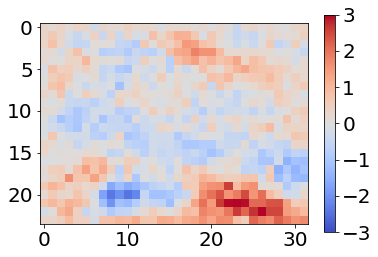

In [42]:
plt.imshow(data_gen[106],cmap='coolwarm',vmin=-3,vmax=3)
plt.colorbar()


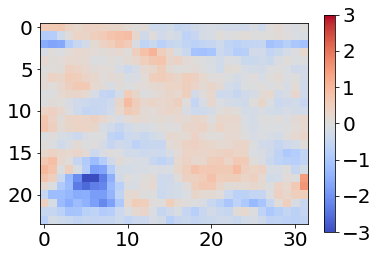

In [50]:
plt.imshow(data_gen[1706],cmap='coolwarm',vmin=-3,vmax=3)
plt.colorbar()

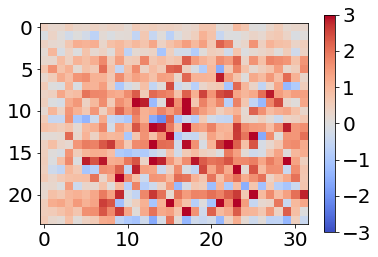

In [42]:
plt.imshow(data_gen[106],cmap='coolwarm',vmin=-3,vmax=3)
plt.colorbar()

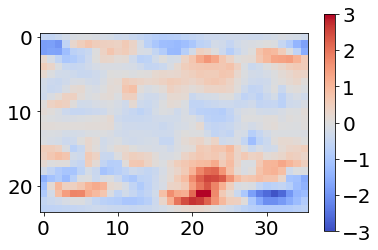

In [51]:
plt.imshow(tas_an_red4[250],cmap='coolwarm',vmin=-3,vmax=3)
plt.colorbar()

In [66]:
tas_an_red4.shape[1]

24

In [51]:
gen_map=np.zeros((data_gen.shape[0],tas_an_red4.shape[1],tas_an_red4.shape[2]))
gen_map.shape

(2000, 24, 36)

In [52]:
gen_map[:,:,2:-2]=data_gen

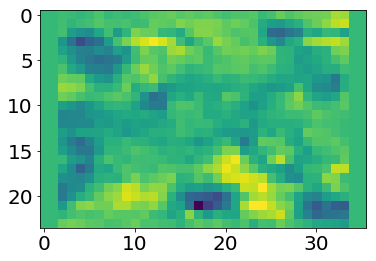

In [53]:
plt.imshow(gen_map[106])

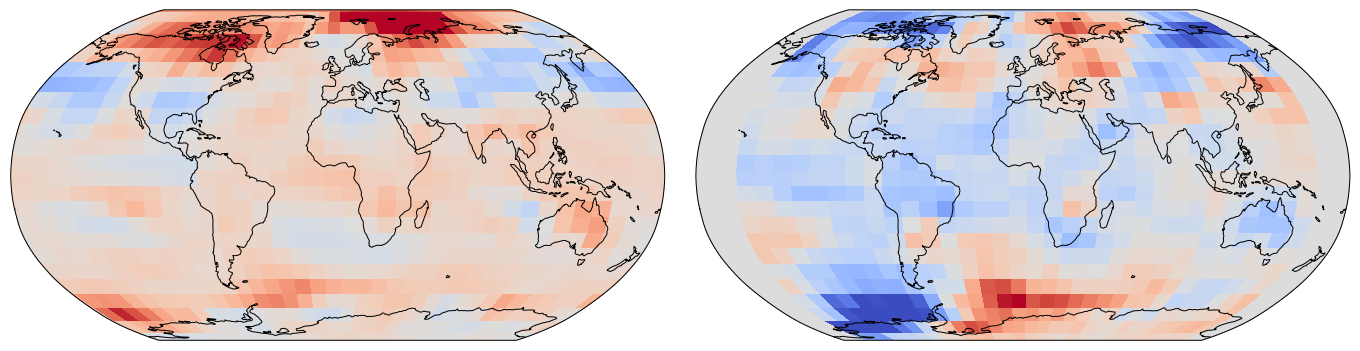

In [54]:
### create the plot
plt.figure(figsize=(24, 18))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.default':'regular'}) 
grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0) # create a grid for the subplots


ax1 = plt.subplot(grid[0,:2], projection=ccrs.Robinson(central_longitude=0))
ax1.coastlines()
mesh = ax1.pcolormesh(lon_pc_red4, lat_pc_red4, tas_an_red4[4500],cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())

ax2 = plt.subplot(grid[0,2:], projection=ccrs.Robinson(central_longitude=0))
ax2.coastlines()
mesh = ax2.pcolormesh(lon_pc_red4, lat_pc_red4, gen_map[55],cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())


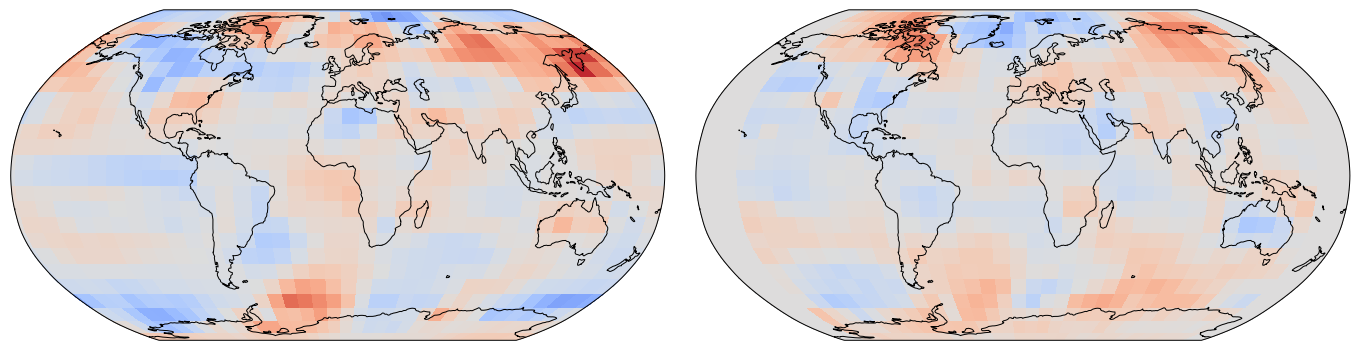

In [70]:
### create the plot
plt.figure(figsize=(24, 18))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.default':'regular'}) 
grid = plt.GridSpec(2, 4, wspace=0.1, hspace=0) # create a grid for the subplots


ax1 = plt.subplot(grid[0,:2], projection=ccrs.Robinson(central_longitude=0))
ax1.coastlines()
mesh = ax1.pcolormesh(lon_pc_red4, lat_pc_red4, tas_an_red4[150],cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())

ax2 = plt.subplot(grid[0,2:], projection=ccrs.Robinson(central_longitude=0))
ax2.coastlines()
mesh = ax2.pcolormesh(lon_pc_red4, lat_pc_red4, gen_map[115],cmap='coolwarm',vmin=-3,vmax=3,transform=ccrs.PlateCarree())


In [66]:
np.unique(data_gen).shape,2000*24*32 # not all unique nrs... but I do not know whether that should worry me...

((966279,), 1536000)